<a href="https://colab.research.google.com/github/KwangryeolPark/Graduate.DGM/blob/master/DQN_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import numpy as np
from collections import deque
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomUniform
import tensorflow as tf

# You can change this part
class NN(tf.keras.Model):
  def __init__(self, action_size):
    super(NN, self).__init__()
    self.fc1 = Dense(24, activation='relu')
    self.fc2 = Dense(24, activation='relu')
    self.fc_out = Dense(action_size, kernel_initializer=RandomUniform(-1e-3, 1e-3))

  def call(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    q = self.fc_out(x)
    return q

class DQN:
  def __init__(self, state_size, aciton_size):
    # size of state and action vector
    self.state_size = state_size
    self.action_size = aciton_size

    self.discount_factor = 0.99
    self.learning_rate = 0.001

    # Parameters for epsilon
    self.epsilon = 1.0 # initial value
    self.epsilon_decay = 0.999 # decay rate
    self.epsilon_min = 0.001 # minimum value

    self.batch_size = 64
    self.train_start = 1000 # fully explore (i.e. epsilon = 1.0) until step

    self.memory = deque(maxlen=100000)

    self.model = NN(action_size)# Neural network with state sized input
    self.target_model = NN(action_size) # same as above
    self.optimizer = Adam(learning_rate=self.learning_rate)

    self.update_target_model() # update target model parameters with model parameters

  def update_target_model(self):
    self.target_model.set_weights(self.model.get_weights())

  # input: state
  # return: action
  # For a random value greater than epsilon, return max action at "state"
  # Else, return random action
  def get_action(self, state):
    # your implementation
    if np.random.rand() <= self.epsilon:
      return random.randrange(self.action_size)
    q_value = self.model(state)
    return np.argmax(q_value[0])

  def append_sample(self, state, action, reward, next_state, done):
    # append your MDP tuples into memory
    self.memory.append((state, action, reward, next_state, done))

  # def epsilon_decay(self):
  #   # for a constant epsilon bigger than minumum value, decay according to the constant epsilon_decay
  #   if self.epsilon > self.epsilon_min:
  #     self.epsilon = self.epsilon * self.epsilon_decay

  def train_model(self):
    if self.epsilon > self.epsilon_min:
      self.epsilon = self.epsilon * self.epsilon_decay

    # Get your random samples from your memory
    # hint: sample mini batch from your memory then assign the corresponding values into separater variables
    mini_batch = random.sample(self.memory, self.batch_size)


    states = np.array([sample[0][0] for sample in mini_batch])
    actions = np.array([sample[1] for sample in mini_batch])
    rewards = np.array([sample[2] for sample in mini_batch])
    next_states = np.array([sample[3][0] for sample in mini_batch])
    dones = np.array([sample[4] for sample in mini_batch])# flag for termination

    model_params = self.model.trainable_variables

    # train your model
    with tf.GradientTape() as tape:
        # select max/random action according to "state"
        predicts = self.model(states)
        one_hot_action = tf.one_hot(actions, self.action_size)
        predicts = tf.reduce_sum(one_hot_action * predicts, axis=1)

        target_predicts = self.target_model(next_states)
        target_predicts = tf.stop_gradient(target_predicts)

        max_q = np.amax(target_predicts, axis=-1)
        # compute target value and loss according to the original paper
        targets = rewards + (1 - dones) * self.discount_factor * max_q
        # update model and target model 
        loss = tf.reduce_mean(tf.square(targets - predicts))
    grads = tape.gradient(loss, model_params)
    self.optimizer.apply_gradients(zip(grads, model_params))
import numpy as np
import gym
# from tqdm import tqdm
from tqdm.notebook import tqdm
print(np.__version__)
# CartPole-v1, Acrobot-v1, MountainCar-v0
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = DQN(state_size, action_size)

Episode_return = []

Epochs = 1000 # You can change this parameter. But, use a same value in DQN and its variation
# YOU MUST FIX "num_steps" EVALUATION PARAMETERS
# If you don't you can get penalty
num_steps = 1000 

for epoch in tqdm(range(Epochs), desc='outer', position=0):
  done = False
  score = 0
  episode_rewards = [0.0]

  # initialize environment
  state = env.reset()
  # print(gym.__version__)
  state = np.reshape(state, [1, state_size])

  for i in tqdm(range(num_steps), desc='inner', position=1, leave=False):
      # get random/max action at "state"
      action = agent.get_action(state)
      # take next step on your environment with selected action
      next_state, reward, done, info = env.step(action)
      # the size of next state must match the size of state vector
      next_state = np.reshape(next_state, [1, state_size])
      
      episode_rewards[-1] += reward

      # Use append_sample function to append your MDP tuples into memory
      agent.append_sample(state, action, reward, next_state, done)

      if len(agent.memory) >= 1000:
        agent.train_model()

      # If not done, repeat with next state
      # Else initialize environment
      if done:
        episode_rewards.append(0.0)

      else:
        state = next_state
        
  if (epoch % 100) == 0 :
      mean_100ep_reward = round(np.mean(episode_rewards[-100:]), 1)
      print(f"{epoch+1}th Mean reward:", mean_100ep_reward, "Num episodes:", len(episode_rewards))
      Episode_return.append(mean_100ep_reward)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1.22.4


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


outer:   0%|          | 0/1000 [00:00<?, ?it/s]

inner:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gym/envs/classic_control/cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


1th Mean reward: 0.0 Num episodes: 975


inner:   0%|          | 0/1000 [00:00<?, ?it/s]

inner:   0%|          | 0/1000 [00:00<?, ?it/s]

inner:   0%|          | 0/1000 [00:00<?, ?it/s]

inner:   0%|          | 0/1000 [00:00<?, ?it/s]

inner:   0%|          | 0/1000 [00:00<?, ?it/s]

inner:   0%|          | 0/1000 [00:00<?, ?it/s]

inner:   0%|          | 0/1000 [00:00<?, ?it/s]

inner:   0%|          | 0/1000 [00:00<?, ?it/s]

inner:   0%|          | 0/1000 [00:00<?, ?it/s]

inner:   0%|          | 0/1000 [00:00<?, ?it/s]

inner:   0%|          | 0/1000 [00:00<?, ?it/s]

inner:   0%|          | 0/1000 [00:00<?, ?it/s]

inner:   0%|          | 0/1000 [00:00<?, ?it/s]

inner:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# You can plot the another evaluation values.
# But, you should include the "Episode_return".
import matplotlib.pyplot as plt

plt.xlabel("Num Episode")
plt.ylabel("Episode returns")
plt.plot(episode_rewards, label='Episode_return')
plt.legend()
plt.savefig('DQN Episode returns')
plt.show()
plt.close()

In [ ]:
import random
import numpy as np
from collections import deque
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomUniform
import tensorflow as tf
import gym
import matplotlib.pyplot as plt

# You can change this part
class NN(tf.keras.Model):
    def __init__(self, action_size):
        super(NN, self).__init__()
        self.fc1 = Dense(24, activation='relu')
        self.fc2 = Dense(24, activation='relu')
        self.fc_out = Dense(action_size, kernel_initializer=RandomUniform(-1e-3, 1e-3))

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.fc_out(x)
        return q

class DQN:
    def __init__(self, state_size, action_size):
        # size of state and action vector
        self.state_size = state_size
        self.action_size = action_size

        self.discount_factor = 0.99
        self.learning_rate = 0.001

        # Parameters for epsilon
        self.epsilon = 1.0 # initial value
        self.epsilon_decay = 0.999 # decay rate
        self.epsilon_min = 0.001 # minimum value

        self.batch_size = 64
        self.train_start = 1000 # fully explore (i.e. epsilon = 1.0) until step

        self.memory = deque(maxlen=100000)

        self.model = NN(action_size)
        self.target_model = NN(action_size)
        self.optimizer = Adam(learning_rate=self.learning_rate)

        self.update_target_model() # update target model parameters with model parameters

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # input: state
    # return: action
    # For a random value greater than epsilon, return max action at "state"
    # Else, return random action
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_values = self.model.predict(state)
            return np.argmax(q_values[0])

    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def epsilon_decay(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train_model(self):
        self.epsilon_decay()

        # Get your random samples from your memory
        mini_batch = random.sample(self.memory, self.batch_size)

        states = np.array([sample[0] for sample in mini_batch])
        actions = np.array([sample[1] for sample in mini_batch])
        rewards = np.array([sample[2] for sample in mini_batch])
        next_states = np.array([sample[3] for sample in mini_batch])
        dones = np.array([sample[4] for sample in mini_batch])

        model_params = self.model.trainable_variables

        # Train your model
        with tf.GradientTape() as tape:
            q_values = self.model(states)
            one_hot_actions = tf.keras.utils.to_categorical(actions, self.action_size)
            q_values = tf.reduce_sum(tf.multiply(q_values, one_hot_actions), axis=1)

            target_q_values = tf.reduce_max(self.target_model(next_states), axis=1)
            target_q_values = rewards + (1 - dones) * self.discount_factor * target_q_values

            loss = tf.reduce_mean(tf.square(target_q_values - q_values))

        grads = tape.gradient(loss, model_params)
        self.optimizer.apply_gradients(zip(grads, model_params))

        # Update target model
        if len(self.memory) % self.train_start == 0:
            self.update_target_model()
################################################################
################

# CartPole-v1, Acrobot-v1, MountainCar-v0
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = DQN(state_size, action_size)

Episode_return = []

Epochs = 1000  # You can change this parameter. But, use the same value in DQN and its variation
# YOU MUST FIX "num_steps" EVALUATION PARAMETERS
# If you don't, you can get a penalty
num_steps = 1000

for epoch in range(Epochs):
    done = False
    score = 0
    episode_rewards = [0.0]

    # initialize environment
    state = env.reset()
    state = np.reshape(state, [1, state_size])

    for i in range(num_steps):
        # get random/max action at "state"
        action = agent.get_action(state)

        # take the next step on your environment with the selected action
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])

        episode_rewards[-1] += reward

        # Use append_sample function to append your MDP tuples into memory
        agent.append_sample(state, action, reward, next_state, done)

        if len(agent.memory) >= 1000:
            agent.train_model()

        # If not done, repeat with the next state
        if done:
            episode_rewards.append(0.0)
            break
        else:
            state = next_state

    if (epoch % 100) == 0:
        mean_100ep_reward = round(np.mean(episode_rewards[-100:]), 1)
        print(f"{epoch+1}th Mean reward:", mean_100ep_reward, "Num episodes:", len(episode_rewards))
        Episode_return.append(mean_100ep_reward)

# Plotting episode returns
plt.xlabel("Num Episode")
plt.ylabel("Episode returns")
plt.plot(Episode_return, label='Episode_return')
plt.legend()
plt.savefig('DQN Episode returns')
plt.show()
plt.close()


In [ ]:
import os
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomUniform


# 상태가 입력, 큐함수가 출력인 인공신경망 생성
class DQN(tf.keras.Model):
    def __init__(self, action_size):
        super(DQN, self).__init__()
        self.fc1 = Dense(24, activation='relu')
        self.fc2 = Dense(24, activation='relu')
        self.fc_out = Dense(action_size,
                            kernel_initializer=RandomUniform(-1e-3, 1e-3))

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.fc_out(x)
        return q


# 카트폴 예제에서의 DQN 에이전트
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.render = False

        # 상태와 행동의 크기 정의
        self.state_size = state_size
        self.action_size = action_size

        # DQN 하이퍼파라미터
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000

        # 리플레이 메모리, 최대 크기 2000
        self.memory = deque(maxlen=2000)

        # 모델과 타깃 모델 생성
        self.model = DQN(action_size)
        self.target_model = DQN(action_size)
        self.optimizer = Adam(lr=self.learning_rate)

        # 타깃 모델 초기화
        self.update_target_model()

    # 타깃 모델을 모델의 가중치로 업데이트
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # 입실론 탐욕 정책으로 행동 선택
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model(state)
            return np.argmax(q_value[0])

    # 샘플 <s, a, r, s'>을 리플레이 메모리에 저장
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # 리플레이 메모리에서 무작위로 추출한 배치로 모델 학습
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # 메모리에서 배치 크기만큼 무작위로 샘플 추출
        mini_batch = random.sample(self.memory, self.batch_size)

        states = np.array([sample[0][0] for sample in mini_batch])
        actions = np.array([sample[1] for sample in mini_batch])
        rewards = np.array([sample[2] for sample in mini_batch])
        next_states = np.array([sample[3][0] for sample in mini_batch])
        dones = np.array([sample[4] for sample in mini_batch])

        # 학습 파라메터
        model_params = self.model.trainable_variables
        with tf.GradientTape() as tape:
            # 현재 상태에 대한 모델의 큐함수
            predicts = self.model(states)
            one_hot_action = tf.one_hot(actions, self.action_size)
            predicts = tf.reduce_sum(one_hot_action * predicts, axis=1)

            # 다음 상태에 대한 타깃 모델의 큐함수
            target_predicts = self.target_model(next_states)
            target_predicts = tf.stop_gradient(target_predicts)

            # 벨만 최적 방정식을 이용한 업데이트 타깃
            max_q = np.amax(target_predicts, axis=-1)
            targets = rewards + (1 - dones) * self.discount_factor * max_q
            loss = tf.reduce_mean(tf.square(targets - predicts))

        # 오류함수를 줄이는 방향으로 모델 업데이트
        grads = tape.gradient(loss, model_params)
        self.optimizer.apply_gradients(zip(grads, model_params))


if __name__ == "__main__":
    # CartPole-v1 환경, 최대 타임스텝 수가 500
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # DQN 에이전트 생성
    agent = DQNAgent(state_size, action_size)

    scores, episodes = [], []
    score_avg = 0

    Epochs = 300
    for e in range(Epochs):
        done = False
        score = 0
        # env 초기화
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        while not done:
            if agent.render:
                env.render()

            # 현재 상태로 행동을 선택
            action = agent.get_action(state)
            # 선택한 행동으로 환경에서 한 타임스텝 진행
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])

            # 타임스텝마다 보상 0.1, 에피소드가 중간에 끝나면 -1 보상
            score += reward
            reward = 0.1 if not done or score == 500 else -1

            # 리플레이 메모리에 샘플 <s, a, r, s'> 저장
            agent.append_sample(state, action, reward, next_state, done)
            # 매 타임스텝마다 학습
            if len(agent.memory) >= agent.train_start:
                agent.train_model()

            state = next_state

            if done:
                # 각 에피소드마다 타깃 모델을 모델의 가중치로 업데이트
                agent.update_target_model()
                # 에피소드마다 학습 결과 출력
                score_avg = 0.9 * score_avg + 0.1 * score if score_avg != 0 else score
                print("episode: {:3d} | score avg: {:3.2f} | memory length: {:4d} | epsilon: {:.4f}".format(
                      e, score_avg, len(agent.memory), agent.epsilon))

                # 에피소드마다 학습 결과 그래프로 저장
                scores.append(score_avg)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.xlabel("episode")
                pylab.ylabel("average score")
                pylab.savefig("./save_graph/graph.png")

                # 이동 평균이 400 이상일 때 종료
                if score_avg > 400:
                    agent.model.save_weights("./save_model/model", save_format="tf")
                    sys.exit()

score: 1.0 reward: 0.1
score: 2.0 reward: 0.1
score: 3.0 reward: 0.1
score: 4.0 reward: 0.1
score: 5.0 reward: 0.1
score: 6.0 reward: 0.1
score: 7.0 reward: 0.1
score: 8.0 reward: 0.1
score: 9.0 reward: 0.1
score: 10.0 reward: 0.1
score: 11.0 reward: 0.1
score: 12.0 reward: 0.1
score: 13.0 reward: 0.1
score: 14.0 reward: 0.1
score: 15.0 reward: 0.1
score: 16.0 reward: 0.1
score: 17.0 reward: -1
score :  17.0 score_avg: 17.0 agent_epsilon: 1.0
score: 1.0 reward: 0.1
score: 2.0 reward: 0.1
score: 3.0 reward: 0.1
score: 4.0 reward: 0.1
score: 5.0 reward: 0.1
score: 6.0 reward: 0.1
score: 7.0 reward: 0.1
score: 8.0 reward: 0.1
score: 9.0 reward: 0.1
score: 10.0 reward: 0.1
score: 11.0 reward: 0.1
score: 12.0 reward: 0.1
score: 13.0 reward: 0.1
score: 14.0 reward: 0.1
score: 15.0 reward: 0.1
score: 16.0 reward: 0.1
score: 17.0 reward: 0.1
score: 18.0 reward: 0.1
score: 19.0 reward: -1
score :  19.0 score_avg: 17.2 agent_epsilon: 1.0
score: 1.0 reward: 0.1
score: 2.0 reward: 0.1
score: 3.0 r

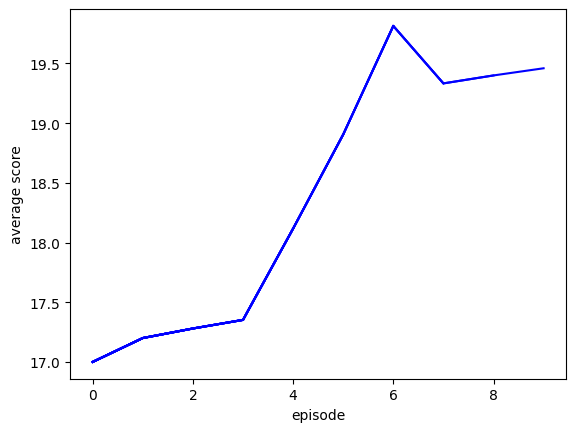

In [ ]:
import os
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomUniform


# 상태가 입력, 큐함수가 출력인 인공신경망 생성
class DQN(tf.keras.Model):
    def __init__(self, action_size):
        super(DQN, self).__init__()
        self.fc1 = Dense(24, activation='relu')
        self.fc2 = Dense(24, activation='relu')
        self.fc_out = Dense(action_size,
                            kernel_initializer=RandomUniform(-1e-3, 1e-3))

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.fc_out(x)
        return q


# 카트폴 예제에서의 DQN 에이전트
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.render = False

        # 상태와 행동의 크기 정의
        self.state_size = state_size
        self.action_size = action_size

        # DQN 하이퍼파라미터
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000

        # 리플레이 메모리, 최대 크기 2000
        self.memory = deque(maxlen=2000)

        # 모델과 타깃 모델 생성
        self.model = DQN(action_size)
        self.target_model = DQN(action_size)
        self.optimizer = Adam(lr=self.learning_rate)

        # 타깃 모델 초기화
        self.update_target_model()

    # 타깃 모델을 모델의 가중치로 업데이트
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # 입실론 탐욕 정책으로 행동 선택
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model(state)
            return np.argmax(q_value[0])

    # 샘플 <s, a, r, s'>을 리플레이 메모리에 저장
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # 리플레이 메모리에서 무작위로 추출한 배치로 모델 학습
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # 메모리에서 배치 크기만큼 무작위로 샘플 추출
        mini_batch = random.sample(self.memory, self.batch_size)

        states = np.array([sample[0][0] for sample in mini_batch])
        actions = np.array([sample[1] for sample in mini_batch])
        rewards = np.array([sample[2] for sample in mini_batch])
        next_states = np.array([sample[3][0] for sample in mini_batch])
        dones = np.array([sample[4] for sample in mini_batch])

        # 학습 파라메터
        model_params = self.model.trainable_variables
        with tf.GradientTape() as tape:
            # 현재 상태에 대한 모델의 큐함수
            predicts = self.model(states)
            one_hot_action = tf.one_hot(actions, self.action_size)
            predicts = tf.reduce_sum(one_hot_action * predicts, axis=1)

            # 다음 상태에 대한 타깃 모델의 큐함수
            target_predicts = self.target_model(next_states)
            target_predicts = tf.stop_gradient(target_predicts)

            # 벨만 최적 방정식을 이용한 업데이트 타깃
            max_q = np.amax(target_predicts, axis=-1)
            targets = rewards + (1 - dones) * self.discount_factor * max_q
            loss = tf.reduce_mean(tf.square(targets - predicts))

        # 오류함수를 줄이는 방향으로 모델 업데이트
        grads = tape.gradient(loss, model_params)
        self.optimizer.apply_gradients(zip(grads, model_params))


if __name__ == "__main__":
    # CartPole-v1 환경, 최대 타임스텝 수가 500
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # DQN 에이전트 생성
    agent = DQNAgent(state_size, action_size)

    scores, episodes = [], []
    score_avg = 0

    num_episode = 10
    for e in range(num_episode):
        done = False
        score = 0
        # env 초기화
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        while not done:
            if agent.render:
                env.render()

            # 현재 상태로 행동을 선택
            action = agent.get_action(state)
            # 선택한 행동으로 환경에서 한 타임스텝 진행
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])

            # 타임스텝마다 보상 0.1, 에피소드가 중간에 끝나면 -1 보상
            score += reward
            reward = 0.1 if not done or score == 500 else -1
            print("score:", score, "reward:", reward)
            # print("score : {:3d} | rewrad : {:3d}".format(score, reward))
            # 리플레이 메모리에 샘플 <s, a, r, s'> 저장
            agent.append_sample(state, action, reward, next_state, done)
            # 매 타임스텝마다 학습
            if len(agent.memory) >= agent.train_start:
                agent.train_model()

            state = next_state

            if done:
                # 각 에피소드마다 타깃 모델을 모델의 가중치로 업데이트
                agent.update_target_model()
                # 에피소드마다 학습 결과 출력
                score_avg = 0.9 * score_avg + 0.1 * score if score_avg != 0 else score
                print("score : ",score,"score_avg:",score_avg,"agent_epsilon:",agent.epsilon)
                # print("score :  | score_avg : {:3d} | agent.epsilon : {:3d}".format(score, score_avg, agent.epsilon))
                # print("episode: {:3d} | score avg: {:3.2f} | memory length: {:4d} | epsilon: {:.4f}".format(
                #       e, score_avg, len(agent.memory), agent.epsilon))

                # 에피소드마다 학습 결과 그래프로 저장
                scores.append(score_avg)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.xlabel("episode")
                pylab.ylabel("average score")
                pylab.savefig("./graph.png")

                # 이동 평균이 400 이상일 때 종료
                if score_avg > 400:
                    agent.model.save_weights("./model", save_format="tf")
                    sys.exit()

In [ ]:
a